## Tarea 5
#### Covid-19 infección en Ecuador. Modelos matemáticos y predicciones
#### Nombre: Carlos Andrade

Una comparación de modelos, lineal, polilnomico,logísticos y exponenciales aplicados a la infección por el virus Covid-19

Se realiza un análisis matemático simple del crecimiento de la infección en Python y dos modelos para comprender mejor la evolución de la infección.

Se crea modelos de series temporales del número total de personas infectadas hasta la fecha (es decir, las personas realmente infectadas más las personas que han sido infectadas). Estos modelos tienen parámetros , que se estimarán por ajuste de curva.

In [11]:
# Importar las librerias para el analasis
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline
from xml.dom import minidom

# Actualizar los datos (URL) 
#datos tomados de https://www.google.com/covid19/mobility/
#https://github.com/owid/covid-19-data/tree/master/public/data
#url = 'Libro1.xlsx'
url = 'owid-covid-data.csv'
df = pd.read_csv(url)
df= df.fillna(1)
df

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,1.000,1.0,0.0,1.0,...,35973.781,1.0,1.0,11.62,1.0,1.0,1.0,1.0,76.29,1.0
1,ABW,North America,Aruba,2020-03-19,1.0,1.0,0.286,1.0,1.0,0.0,...,35973.781,1.0,1.0,11.62,1.0,1.0,1.0,1.0,76.29,1.0
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,1.0,0.0,0.0,...,35973.781,1.0,1.0,11.62,1.0,1.0,1.0,1.0,76.29,1.0
3,ABW,North America,Aruba,2020-03-21,1.0,1.0,0.286,1.0,1.0,0.0,...,35973.781,1.0,1.0,11.62,1.0,1.0,1.0,1.0,76.29,1.0
4,ABW,North America,Aruba,2020-03-22,1.0,1.0,0.286,1.0,1.0,0.0,...,35973.781,1.0,1.0,11.62,1.0,1.0,1.0,1.0,76.29,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54385,1,1,International,2020-10-30,696.0,1.0,1.000,7.0,1.0,1.0,...,1.000,1.0,1.0,1.00,1.0,1.0,1.0,1.0,1.00,1.0
54386,1,1,International,2020-10-31,696.0,1.0,1.000,7.0,1.0,1.0,...,1.000,1.0,1.0,1.00,1.0,1.0,1.0,1.0,1.00,1.0
54387,1,1,International,2020-11-01,696.0,1.0,1.000,7.0,1.0,1.0,...,1.000,1.0,1.0,1.00,1.0,1.0,1.0,1.0,1.00,1.0
54388,1,1,International,2020-11-02,696.0,1.0,1.000,7.0,1.0,1.0,...,1.000,1.0,1.0,1.00,1.0,1.0,1.0,1.0,1.00,1.0


In [12]:
df = df[df['location'].isin(['Ecuador'])] #Filtro la Informacion solo para Ecuador
df = df.loc[:,['date','total_cases','iso_code']] #Selecciono las columnas de analasis
# Expresar las fechas en numero de dias desde el 01 Enero
FMT = '%Y-%m-%d'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2019-12-30", FMT)).days)

df
#data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]


,date,total_cases,iso_code
14369,1,1.0,ECU
14370,2,1.0,ECU
14371,3,1.0,ECU
14372,4,1.0,ECU
14373,5,1.0,ECU
...,...,...,...
14673,305,166302.0,ECU
14674,306,167147.0,ECU
14675,307,168192.0,ECU
14676,308,169194.0,ECU


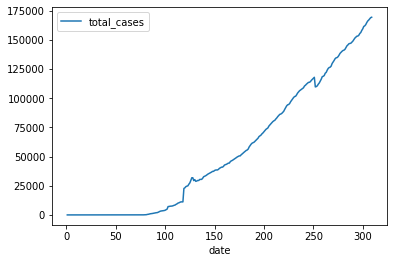

In [13]:
df.plot(x ='date', y='total_cases')
#df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
#df['Ecuador']=df['Ecuador'].fillna(0) #Reemplaza con ceros 
#df = df.replace(np.nan, 1)
#df.describe()

Ahora podemos analizar los cuatro modelos que tomaré en el examen, que son la función lineal, polinomica,logística y la función exponencial . Cada modelo tiene tres parámetros , que se estimarán mediante un cálculo de ajuste de curva en los datos históricos.

## EL modelo lineal

La regresión lineal es un algoritmo de aprendizaje supervisado que se utiliza en Machine Learning y en estadística. En su versión más sencilla, lo que haremos es «dibujar una recta» que nos indicará la tendencia de un conjunto de datos continuos.

Recordemos rápidamente la fórmula de la recta:

Y = mX + b

In [14]:

x = list(df.iloc [:, 0]) # Fecha
y = list(df.iloc [:, 1]) # Numero de casos
# Creamos el objeto de Regresión Lineal
regr = linear_model.LinearRegression()

# Entrenamos nuestro modelo
regr.fit(np.array(x).reshape(-1, 1) ,y)

# Veamos los coeficienetes obtenidos, En nuestro caso, serán la Tangente
print('Coefficients: \n', regr.coef_)
# Este es el valor donde corta el eje Y (en X=0)
print('Independent term: \n', regr.intercept_)
# Error Cuadrado Medio

Coefficients: 
 [580.86433961]
Independent term: 
 -35540.02118270082


In [17]:

#Vamos a comprobar:
# Quiero predecir cuántos "Casos" voy a obtener por en el dia 100,
# según nuestro modelo, hacemos:
cantidad = int(input("ESCRIBA NUMERO DE DIAS: "))
y_prediccion = regr.predict([[cantidad]])
print('Para el dia',cantidad ,'hay estos casos: ',int(y_prediccion))

ESCRIBA NUMERO DE DIAS: 20
Para el dia 20 hay estos casos:  -23922


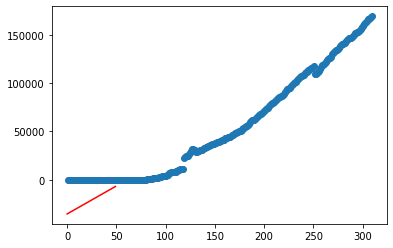

In [16]:
#Graficar
plt.scatter(x, y)
x_real = np.array(range(0, 50))
#print(x_real)
plt.plot(x_real, regr.predict(x_real.reshape(-1, 1)), color='red')
plt.show()

## El modelo logistico

El modelo logístico se ha utilizado ampliamente para describir el crecimiento de una población. Una infección puede describirse como el crecimiento de la población de un agente patógeno, por lo que un modelo logístico parece razonable .
La expresión más genérica de una función logística es:
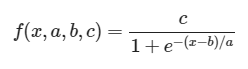
En esta fórmula, tenemos la variable x que es el tiempo y tres parámetros: a, b, c .

- a se refiere a la velocidad de infección
- b es el día en que ocurrieron las infecciones máximas
- c es el número total de personas infectadas registradas al final de la infección

In [18]:
def modelo_logistico(x,a,b):
    return a+b*np.log(x)

exp_fit = curve_fit(modelo_logistico,x,y) #Extraemos los valores de los paramatros
print(exp_fit)


(array([-142194.01233739,   41446.44320273]), array([[ 1.06751126e+08, -2.16021721e+07],
       [-2.16021721e+07,  4.55204871e+06]]))


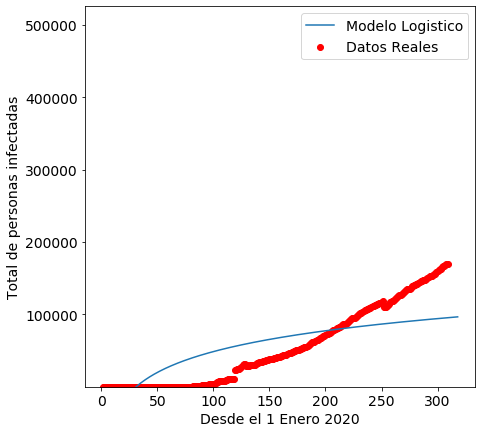

In [19]:
pred_x = list(range(min(x),max(x)+10)) # Predecir 50 dias mas
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)
# Real data
plt.scatter(x,y,label="Datos Reales",color="red")
# Predicted exponential curve
plt.plot(pred_x, [modelo_logistico(i,exp_fit[0][0],exp_fit[0][1]) for i in pred_x], label="Modelo Logistico" )
plt.legend()
plt.xlabel("Desde el 1 Enero 2020")
plt.ylabel("Total de personas infectadas")
plt.ylim((min(y)*0.9,max(y)*3.1)) # Definir los limites de Y
plt.show()

## Modelo exponencial

Mientras que el modelo logístico describe un crecimiento de infección que se detendrá en el futuro, el modelo exponencial describe un crecimiento de infección imparable . Por ejemplo, si un paciente infecta a 2 pacientes por día, después de 1 día tendremos 2 infecciones, 4 después de 2 días, 8 después de 3 y así sucesivamente.
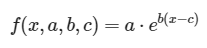

## Implementar el modelo Polinomial

----------------RESPUESTA OBTENIDA en 7 DIAS------------
Se hace cuenta desde el dia(30) y se suma 7 dias, PREDICCION: 2653.0 contagiados


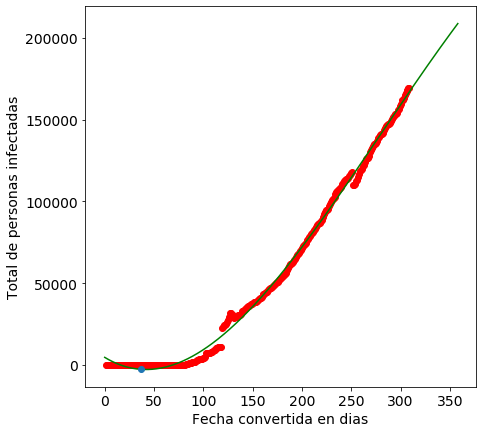

In [20]:

from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures 

pf = PolynomialFeatures(degree = 4)
X = pf.fit_transform(np.array(x).reshape(-1, 1))
regresion_lineal = LinearRegression()
regresion_lineal.fit(X, y) 
pred_x = list(range(0,max(x)+50))

puntos = pf.fit_transform(np.array(pred_x).reshape(-1, 1))
prediccion_entrenamiento = regresion_lineal.predict(puntos)
respuesta =  round(-(prediccion_entrenamiento[37]))
print('----------------RESPUESTA OBTENIDA en 7 DIAS------------')
print ('Se hace cuenta desde el dia(30) y se suma 7 dias, PREDICCION:',respuesta, 'contagiados')
plt.plot(pred_x, prediccion_entrenamiento, color='green')
plt.scatter(x,y,label="Datos Reales",color="red")
plt.xlabel("Fecha convertida en dias")
plt.ylabel("Total de personas infectadas")
plt.plot(37,prediccion_entrenamiento[37], 'o')
plt.show()

#### Conclusiones
los modelos dependiendo de los datos se pueden implementar y unos tener mejores resultados que otros para ello es necesario ver el crecimiento y un estudio de los datos actuales los cuales deterinaran cual es el modelo que mas se aproxime a la realidad.
#### Criterio personal (politico, economico y social de la situacion)
podemos apreciar un creciemiento en los casos como se ve en la simulacion dado que no contamos con un sistema de salud adecuado las personas no toman conciencia de las consecuencias de esta pandemia y las reprecurciones que podria allegar a tener.
#### Referencias
https://www.researchgate.net/publication/340092755_Infeccion_del_Covid-19_en_Colombia_Una_comparacion_de_modelos_logisticos_y_exponenciales_aplicados_a_la_infeccion_por_el_virus_en_Colombia

https://www.aprendemachinelearning.com/regresion-lineal-en-espanol-con-python/

https://ourworldindata.org/coronavirus-data